# GRB 190829A 3d Analysis
#### Step 1: Data preparation and reduction

- The objective of this analysis is to produce 3d maps of GRB 190829A. 
- We will aso fit the spacial and spectral model on the dataset to produce the spectra dataset of the source. 
- Finally we will produce the flux points.

In [1]:
#### imports modules

%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord
from regions import CircleSkyRegion
from pathlib import Path
import scipy.optimize

from gammapy.data import DataStore
from gammapy.maps import MapAxis, WcsGeom
from gammapy.maps import WcsGeom, MapAxis, Map
from gammapy.datasets import MapDataset, Datasets
from gammapy.makers import MapDatasetMaker, SafeMaskMaker, FoVBackgroundMaker
from gammapy.modeling.models import (
    PowerLawSpectralModel, 
    SkyModel, 
    PointSpatialModel, 
    Models,
)
from gammapy.modeling import Fit
from gammapy.estimators import ExcessMapEstimator
from gammapy.estimators.utils import find_peaks
from gammapy.visualization import plot_contour_line
from gammapy.estimators import FluxPointsEstimator
from gammapy.datasets import (
    Datasets,
    SpectrumDataset,
    SpectrumDatasetOnOff,
    FluxPointsDataset,
)


import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from astropy import units as u
from astropy.coordinates import SkyCoord
from regions import CircleSkyRegion

from gammapy.data import DataStore
from gammapy.datasets import MapDataset, FluxPointsDataset
from gammapy.maps import WcsGeom, MapAxis, Map
from gammapy.makers import MapDatasetMaker, SafeMaskMaker, FoVBackgroundMaker
from gammapy.modeling.models import (
    SkyModel,
    PowerLawSpectralModel,
    PointSpatialModel,
)
from gammapy.modeling import Fit
from gammapy.estimators import FluxPointsEstimator

In [2]:
# Initialize the saving folder, format for the plots.

run_list = 'night1'
work_dir = "/Users/jean/Documents/PhD/gammapy/GRBs/190829A/v17/"
def save(fig, figname, left = 0.15, bottom = 0.15, right = 0.95, top = 0.95):
    fig.subplots_adjust(left = left, bottom = bottom, top = top, right = right)
    format_fig = ['png','pdf', 'eps']
    for form in format_fig:
        fig.savefig(work_dir + "plots/plots_3D/{}/jupyter_notebooked/grb190829A_{}_{}.{}"
                    .format(run_list,run_list, figname, form))
W = 12

params = {'figure.figsize': (W, W/(4/3)),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large',
          'font.size' : 14,
         'text.usetex': True,
          'font.family': "sans-serif",
          'legend.fontsize': 14,
          }
plt.rcParams.update(params)

## Defining the datastore and selecting observations

- We first use the `~gammapy.data.DataStore` object to access the observations we want to analyse.
- Here it points to HESS IU period std_Impact_fullEclosure data.

In [3]:
def get_runlist(run_list):
    cluster1 = [152900, 152901]
    cluster2 = [152902, 152903, 152904]
    cluster3 = [152905, 152906, 152907]

    runs_night1 = [152900, 152901, 152902, 152903, 152904, 152905, 152906, 152907]
    runs_hybrid = [152900, 152901, 152902, 152903, 152904, 152905]
    runs_night2 = [152960, 152961, 152962, 152963, 152965, 152966, 152967, 152968, 152969, 152970]
    runs_night3 = [153040, 153041, 153042, 153043, 153044, 153047, 153048, 153049, 153050] # 153045 (too short)


    options = ["night1","night2","night3","all","cluster1","cluster2","cluster3"]

    if run_list not in options:
        print("Invalid option,use\n")
        print(options)
        return []

    else:
        if run_list == 'night1':
            runs = runs_night1
        elif run_list == 'night2':
            runs = runs_night2
        elif run_list == 'night3':
            runs = runs_night3
        elif run_list == 'all':
            runs = runs_night1 + runs_night2 + runs_night3
        elif run_list == "cluster1":
            runs = cluster1
        elif run_list == "cluster2":
            runs = cluster2
        elif run_list == "cluster3":
            runs = cluster3
        elif run_list == "hybrid":
            runs = runs_hybrid
        return runs

In [4]:
def load_data(runs):
    # Load FITS data from H.E.S.S database/local cpu
    ds = DataStore.from_dir("$GAMMAPY_DATA/std_ImPACT_fullEnclosure")
    observations = ds.get_observations(runs)
    return observations, ds

In [5]:
# we load the data here:
runs = get_runlist(run_list)
observations, datastore = load_data(runs)
#print(observations)

## Preparing reduced datasets geometry

Now we define a reference geometry for our analysis. This part is especially important. 
- We have to define first energy axes. They define the axes of the resulting `~gammapy.datasets.MapDataset`. In particular, we have to be careful to the true energy axis: it has to cover a larger range than the reconstructed energy one.
- Then we define the spatial geometry itself. We choose a WCS based geometry with a binsize of 0.02 deg with 5° width.

In [6]:
position = SkyCoord(44.544,-8.958, unit='deg', frame='icrs')

#energy = MapAxis.from_energy_bounds(0.1,40,nbin=16, per_decade=True, unit='TeV')
#energy_true = MapAxis.from_energy_bounds(0.05,500,nbin=16, per_decade=True, unit='TeV', name="energy_true")
energy_axis = MapAxis.from_edges(
    np.logspace(-1, 2, 49), unit='TeV', name='energy', interp='log'
)
geom = WcsGeom.create(    
    skydir=position,
    binsz=0.02,
    width=(4, 4),
    frame="icrs",
    proj="CAR",
    axes=[energy_axis],
)



- We create an empty dataset that will serve as the reference geometry and will be used to stack the individual datasets.

In [7]:
stacked = MapDataset.create(
    geom=geom, name="grb_stacked"
)

## Data reduction

### Create the maker classes to be used

#### Select the safe mask methods to apply
- The `~gammapy.datasets.MapDatasetMaker` object is initialized as well as the `~gammapy.makers.SafeMaskMaker` that carries here a maximum offset selection.
- To be safe w.r.t. background model uncertainties, we also use the `"bkg-peak"` option which selects only energies above the energy where the background rate is maximal.

In [8]:
offset_max = 2.5 * u.deg
maker = MapDatasetMaker()
#maker_safe_mask = SafeMaskMaker(methods=["offset-max", "bkg-peak",'edisp-bias'], offset_max=offset_max, position=position, bias_percent=10)
maker_safe_mask = SafeMaskMaker(methods=['offset-max', 'edisp-bias'], offset_max=2.5*u.deg, bias_percent=10)


## Select the background normalization maker
- The background is obtained by interpolation and integration of the template background model distributed with the DL3 data. 
- Because the normalization of this template model is precise at ~10% at best we have to re-normalize it on the data themselves before stacking them. 

- To do so, we use here the FoV background method, where the template background model is normalized on the measured counts. 
- To avoid counting photons from GRB 190829A we create an exclusion mask around it, near VHE sources and we fit the background model map onto the measured counts map.

In [9]:
circle = CircleSkyRegion(
    center=position, radius=0.3 * u.deg
)

# Exclusion region
exclusion_ra = 44.106
exclusion_dec = -8.98981
exclusion_radius = 0.2
exclusion_region = CircleSkyRegion(
center= SkyCoord(exclusion_ra, exclusion_dec, unit="deg", frame="icrs"),
radius= exclusion_radius * u.deg,
)

skydir = position.icrs
exclusion_mask = Map.create(
npix=(150, 150), binsz=0.05, skydir=skydir, proj="TAN", frame="icrs")


data = geom.region_mask(regions=[circle, exclusion_region], inside=False)
exclusion_mask = Map.from_geom(geom=geom, data=data)
maker_fov = FoVBackgroundMaker(method="fit", exclusion_mask=exclusion_mask)

## Perform the data reduction loop.

In [10]:
%%time
datasets = []
for obs in observations:
    # First a cutout of the target map is produced
    cutout = stacked.cutout(
        obs.pointing_radec, width=2 * offset_max, name=f"obs-{obs.obs_id}",
        mode="partial"
    )
    # A MapDataset is filled in this cutout geometry
    dataset = maker.run(cutout, obs)
    # The data quality cut is applied
    dataset = maker_safe_mask.run(dataset, obs)

    # fit background model
    dataset = maker_fov.run(dataset)
    print(
        f"Background norm obs {obs.obs_id}: {dataset.background_model.norm.value:.2f}"
    )
    # if the background norm is completely off scale don't stack run
    if np.abs(dataset.background_model.norm.value-1.)>0.5:
        print("Dropping run.")
        continue
     # The resulting dataset cutout is stacked onto the final one
    datasets.append(dataset)
    stacked.stack(dataset)

/Users/jean/miniconda3/envs/gammapy-0.17/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/jean/miniconda3/envs/gammapy-0.17/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Background norm obs 152900: 0.89


/Users/jean/miniconda3/envs/gammapy-0.17/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/jean/miniconda3/envs/gammapy-0.17/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Background norm obs 152901: 0.95


/Users/jean/miniconda3/envs/gammapy-0.17/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/jean/miniconda3/envs/gammapy-0.17/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Background norm obs 152902: 0.82


/Users/jean/miniconda3/envs/gammapy-0.17/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/jean/miniconda3/envs/gammapy-0.17/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Background norm obs 152903: 0.74


/Users/jean/miniconda3/envs/gammapy-0.17/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/jean/miniconda3/envs/gammapy-0.17/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Background norm obs 152904: 0.84


/Users/jean/miniconda3/envs/gammapy-0.17/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/jean/miniconda3/envs/gammapy-0.17/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Background norm obs 152905: 0.86


/Users/jean/miniconda3/envs/gammapy-0.17/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/jean/miniconda3/envs/gammapy-0.17/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Background norm obs 152906: 0.80


/Users/jean/miniconda3/envs/gammapy-0.17/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/jean/miniconda3/envs/gammapy-0.17/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Background norm obs 152907: 0.90
CPU times: user 37.7 s, sys: 10.1 s, total: 47.7 s
Wall time: 48.3 s


### Inspect the reduced dataset

- We first print the final `MapDataset` content.

In [11]:
print(stacked)

MapDataset
----------

  Name                            : grb_stacked 

  Total counts                    : 20420 
  Total predicted counts          : 20137.39
  Total background counts         : 20137.39

  Exposure min                    : 4.14e+03 m2 s
  Exposure max                    : 3.91e+09 m2 s

  Number of total bins            : 1920000 
  Number of fit bins              : 1760000 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 177956.48

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: BackgroundModel
  
    Name                      : grb_stacked-bkg
    Datasets names            : ['grb_stacked']
    Parameters:
      norm                    :   1.000              
      tilt         (frozen)   :   0.000              
      reference    (frozen)   :   1.000  TeV         
  
  


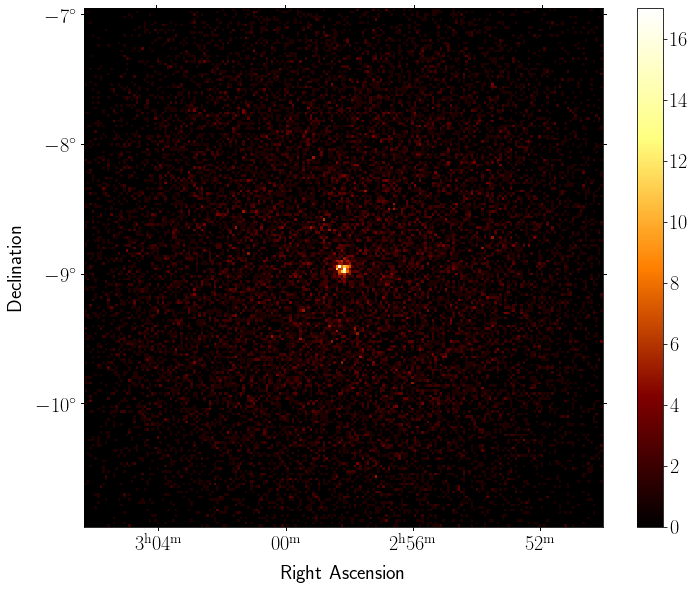

In [12]:
# Counts map
fig = plt.figure()
stacked.counts.sum_over_axes().plot(add_cbar=True);
save(fig, 'Stacked_Counts_maps')

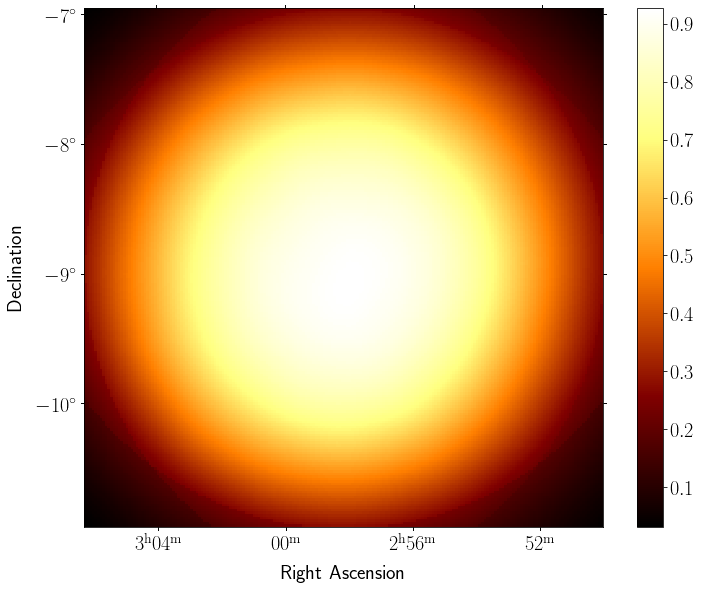

In [13]:
# Background map
fig = plt.figure()
stacked.background_model.evaluate().sum_over_axes().plot(add_cbar= True);
save (fig, 'Background_maps_stacked')

In [14]:
params = {'text.usetex': True,
          'font.family': "sans-serif"
          }
plt.rcParams.update(params)

- It is also useful to look at the reduced data, e.g. with the new functionality `Map.plot_grid`.

- First the counts. The first map is empty. This is because of safe mask definition: during dataset stacking, excluded pixels are set to zero.

- We plot total counts and residuals taking into account the stacked normalized backgrounds.

In [15]:
W = 10

params = {'figure.figsize': (W, W/(4/3)),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large',
          'font.size' : 14,
         'text.usetex': True,
          'font.family': "sans-serif",
          'legend.fontsize': 14,
          }
plt.rcParams.update(params)

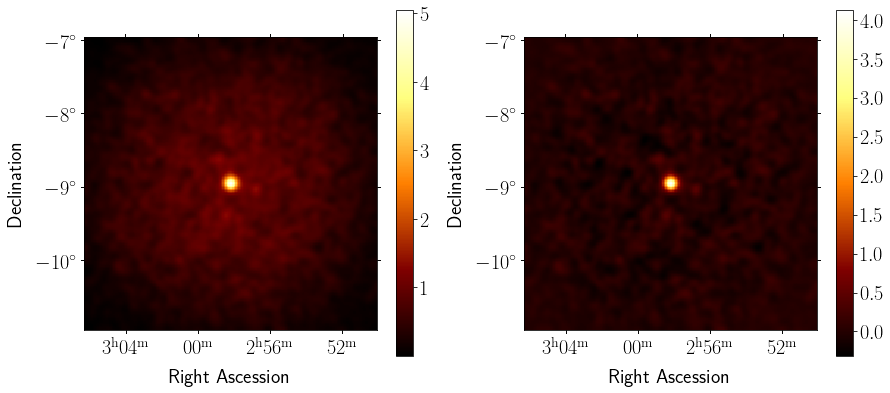

In [16]:
fig = plt.figure(figsize=(14,6))
ax1=plt.subplot(121, projection=stacked.counts.geom.wcs)
_ = stacked.counts.sum_over_axes().smooth(0.05 * u.deg).plot(ax=ax1,  add_cbar=True)
ax1.set_xlabel('Right Ascession', fontsize=20)
ax1.set_ylabel('Declination', fontsize=20)

ax2=plt.subplot(122, projection=stacked.counts.geom.wcs)
_ = stacked.residuals().sum_over_axes().smooth(0.05 * u.deg).plot(ax=ax2, add_cbar=True)
ax2.set_xlabel('Right Ascession', fontsize=20)
ax2.set_ylabel('Declination', fontsize=20)
save(fig, 'counts_and_residial_maps')

- In order to evaluate the existence of source and to measure its position, we perform a 2D analysis first.

- We first add a convenience function to plot significance map with its associated distribution.

- *Note: gammapy relies on matplotlib for map plotting. The correct projection handling is made when creating the subplot. Therefore, when calling `Map.plot(ax=ax)`, you have to define the projection when creating the subplot `ax`. This is done with the argument `projection=geom.wcs`.*

In [17]:
%%time
image_dataset = stacked.to_image(name="grb-image")
#bkg_model = FoVBackgroundModel(dataset_name="grb-image")
#image_dataset.models = [bkg_model]

excess_estimator = ExcessMapEstimator(correlation_radius='0.05 deg')
excess_maps = excess_estimator.run(image_dataset, steps="all")

CPU times: user 40.1 s, sys: 398 ms, total: 40.5 s
Wall time: 40.4 s


### Check the results

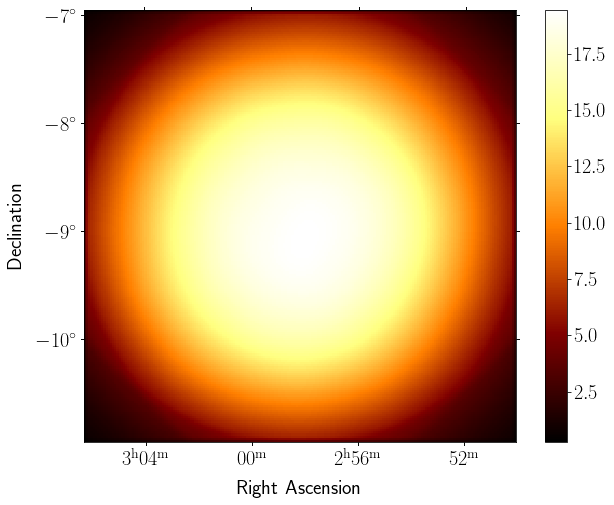

In [18]:
fig = plt.figure()
background_map = excess_maps['background'].sum_over_axes().plot(add_cbar=True);
save(fig, '3d_to_2Dimage_background_maps')

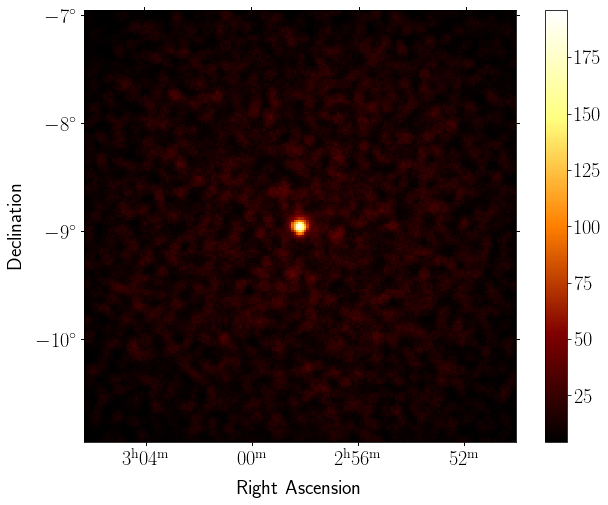

In [19]:
fig = plt.figure()
flux_map = excess_maps["ul"].sum_over_axes().plot(add_cbar=True);
save(fig, '3d_to_2Dimage_upperlimits_map')

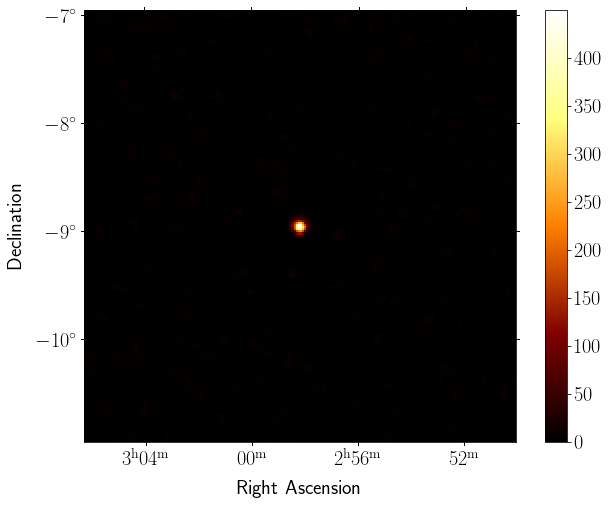

In [20]:
fig = plt.figure()
TS_map = excess_maps["ts"].sum_over_axes().plot(add_cbar=True)
save(fig, '3d_to_2Dimage_TS_map')

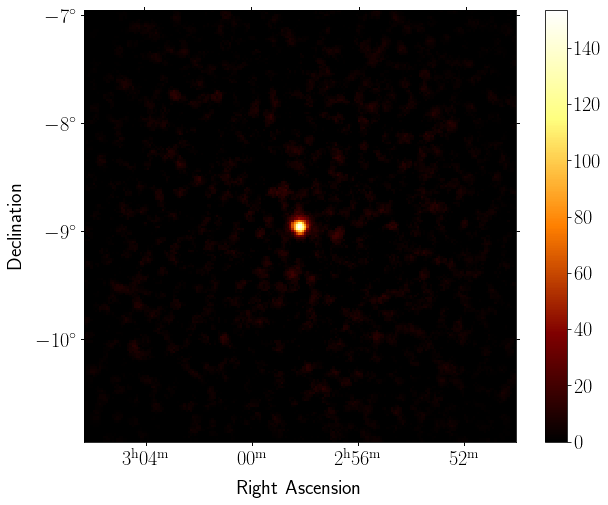

In [21]:
fig = plt.figure()
map_excess_clipped = excess_maps['excess'].copy()
map_excess_clipped.data = map_excess_clipped.data.clip(min = 0)
fig, ax,_ = map_excess_clipped.sum_over_axes().plot(add_cbar = True)
save(fig, '3d_to_2Dimage_excess_map')


In [22]:
W = 10

params = {'figure.figsize': (W, W/(4/3)),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large',
          'font.size' : 14,
         'text.usetex': True,
          'font.family': "sans-serif",
          'legend.fontsize': 14,
          }
plt.rcParams.update(params)

In [23]:
def plot_sqrt_ts_map(sqrt_ts, add_cbar=True, bins=100, figsize=(10,7)):
    from matplotlib.gridspec import GridSpec
    from scipy.stats import norm
    
    fig = plt.figure(figsize=figsize)
    gs = GridSpec(nrows=4, ncols=3, figure=fig)
    ax_map = fig.add_subplot(gs[:,0:2], projection=sqrt_ts.geom.wcs)
    ax_hist = fig.add_subplot(gs[1:3,2])
    ax_res = fig.add_subplot(gs[3,2])

    
    sqrt_ts.plot(ax=ax_map, add_cbar=add_cbar)
    
    # plot significance histogram
    significance = sqrt_ts.data.flatten()
    vals = ax_hist.hist(significance, bins=bins, log=True, density=True)

    # Fit the significance distribution
    valid = np.where(np.abs(significance)<4.0)
    mu, std = norm.fit(significance[valid])
    x = np.linspace(-5, 5, 50)
    p = norm.pdf(x, mu, std)
    ax_hist.plot(x, p, lw=2, color="black")

    plt.setp(ax_res, frame_on=False, xticks=(), yticks=())
    ax_res.text(0.3,0.7, r'$\mu$ = %.3f' %mu)
    ax_res.text(0.3,0.3, r'$\sigma$ = %.3f' %std)
    save(fig,'3d_to_2Dimage_Sign_map_hist_dist')

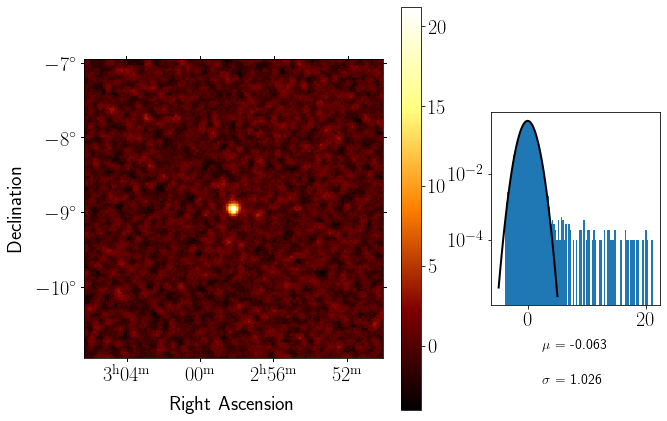

In [24]:
tsmap = plot_sqrt_ts_map(excess_maps["significance"].sum_over_axes())

## Check the residual significance map

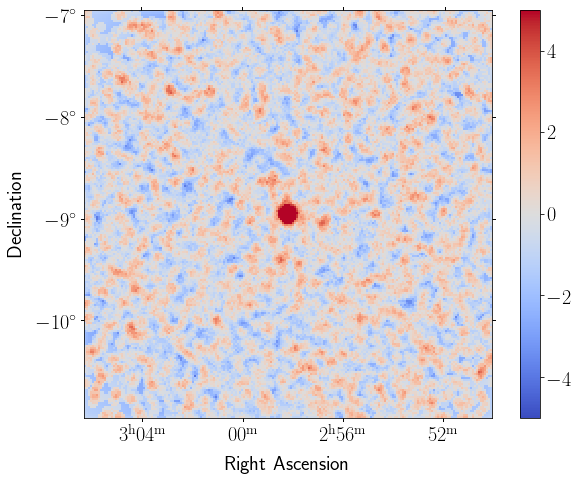

In [25]:
# Residual significance map
res_sign = excess_maps['significance'].sum_over_axes().plot(add_cbar=True, cmap='coolwarm', vmin=-5, vmax=5);

## Source Detection

- Use the class gammapy.estimators.TSMapEstimator and ~gammapy.estimators.utils.find_peaks to detect sources on the images. 
- We search for 0.05 deg sigma gaussian sources in the dataset.

In [26]:
sources = find_peaks(excess_maps["significance"].get_image_by_idx((0,)), threshold= 3)
print(sources)
candidate_position = SkyCoord(sources["ra"], sources["dec"], unit="deg", frame="icrs")


value   x   y     ra       dec   
                 deg       deg   
------ --- --- -------- ---------
21.213  99  99 44.55412  -8.96800
3.8855  42 159 45.70440  -7.76619
3.8202 193  22 42.64282 -10.50317
3.7952  96  77 44.61495  -9.40799
3.7879 116  95 44.20984  -9.04785
3.6051  18 164 46.18828  -7.66436
3.5853  98 106 44.57436  -8.82800
3.5659  23  44 46.09763 -10.06477
3.5305 169 147 43.14051  -8.00535
3.4871 110  24 44.33052 -10.46794
   ... ... ...      ...       ...
 3.155  64  48 45.26481  -9.98730
  3.14   3  32 46.50510 -10.30286
3.1335 167  34 43.17239 -10.26548
3.1314 103  34 44.47288 -10.26799
3.1234 158 142 43.36232  -8.10612
3.1199 144  13 43.63870 -10.68691
3.0864 105  75 44.43249  -9.44798
3.0488  28 192 45.98432  -7.10520
3.0405  25  62 46.05551  -9.70494
3.0095  53 121 45.48437  -8.52681
Length = 30 rows


In [27]:

params = {'figure.figsize': (W, W/(4/3)),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large',
          'font.size' : 14,
         'text.usetex': True,
          'font.family': "sans-serif",
          'legend.fontsize': 14,
          }
plt.rcParams.update(params)

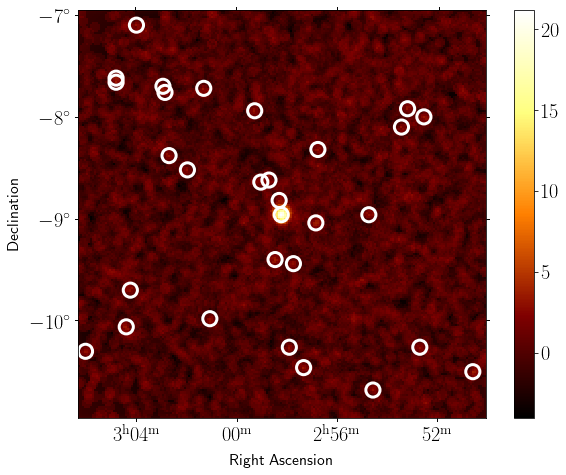

In [28]:
# Plot sources on top of significance sky image
fig = plt.figure()
excess_maps["significance"].sum_over_axes().plot(add_cbar=True);
plt.ylabel('Declination', fontsize = 16)
plt.xlabel("Right Ascension", fontsize = 16)
plt.gca().scatter(
    candidate_position.ra.deg,
    candidate_position.dec.deg,
    transform=plt.gca().get_transform("icrs"),
    color="none",
    edgecolor="white",
    marker="o",
    s=200,
    lw=3,
);

### 2D fitting

- We now create the `SkyModel` which is always the combination of a `SpectralModel` (which carries the flux) and a `SpatialModel`.

In [29]:
spatial_model = PointSpatialModel(
    lon_0=candidate_position[0].ra,
    lat_0=candidate_position[0].dec,
    frame="icrs"
)

spectral_model = PowerLawSpectralModel(
    index=2.502,
    amplitude=1.e-11 * u.Unit("1 / (cm2 s TeV)"),
    reference=0.55 * u.TeV,
)

sky_model = SkyModel(
    spatial_model=spatial_model, spectral_model=spectral_model, name="grb"
)
# We freeze the spectral index 
spectral_model.index.frozen = True

#### We now set the models on the dataset.

- **Note: In v0.18, we set the full list of models, in particular, we need to be careful to include the background model if we want to fit its norm.**
- We instantiate the `Fit` object and run it. We obtain the table of parameters best fit values and associated errors.

In [30]:
image_dataset.models.append(sky_model)
print(image_dataset.models)

Models

Component 0: BackgroundModel

  Name                      : wsmgmkNQ
  Datasets names            : ['grb-image']
  Parameters:
    norm                    :   1.000              
    tilt         (frozen)   :   0.000              
    reference    (frozen)   :   1.000  TeV         

Component 1: SkyModel

  Name                      : grb
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : None
  Parameters:
    index        (frozen)   :   2.502              
    amplitude               :   1.00e-11  1 / (cm2 s TeV)
    reference    (frozen)   :   0.550  TeV         
    lon_0                   :  44.554  deg         
    lat_0                   :  -8.968  deg         




In [31]:
%%time
fit_2d = Fit([image_dataset])
fit_2d_result = fit_2d.run()
print(fit_2d_result)
print(fit_2d_result.parameters.to_table())

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 105
	total stat : 62041.72

   name     value         unit         min        max    frozen   error  
--------- ---------- -------------- ---------- --------- ------ ---------
     norm  9.987e-01                 0.000e+00       nan  False 7.067e-03
     tilt  0.000e+00                       nan       nan   True 0.000e+00
reference  1.000e+00            TeV        nan       nan   True 0.000e+00
    index  2.502e+00                       nan       nan   True 0.000e+00
amplitude  7.336e-12 cm-2 s-1 TeV-1        nan       nan  False 5.053e-13
reference  5.500e-01            TeV        nan       nan   True 0.000e+00
    lon_0  4.455e+01            deg        nan       nan  False 2.867e-03
    lat_0 -8.963e+00            deg -9.000e+01 9.000e+01  False 2.925e-03
CPU times: user 1.21 s, sys: 45.4 ms, total: 1.25 s
Wall time: 1.25 s


## Looking at residual excess and residual significance 

- To check the fit quality, we run the `ExcessMapEstimator` again. It takes into account the source model component into the background and returns the residual excess and its associated significance. 

In [32]:
W = 10

params = {'figure.figsize': (W, W/(4/3)),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large',
          'font.size' : 14,
         'text.usetex': True,
          'font.family': "sans-serif",
          'legend.fontsize': 14,
          }
plt.rcParams.update(params)

In [33]:
def plot_sqrt_ts_map(sqrt_ts, add_cbar=True, bins=100, figsize=(10,7)):
    from matplotlib.gridspec import GridSpec
    from scipy.stats import norm
    
    fig = plt.figure(figsize=figsize)
    gs = GridSpec(nrows=4, ncols=3, figure=fig)
    ax_map = fig.add_subplot(gs[:,0:2], projection=sqrt_ts.geom.wcs)
    ax_hist = fig.add_subplot(gs[1:3,2])
    ax_res = fig.add_subplot(gs[3,2])

    
    sqrt_ts.plot(ax=ax_map, add_cbar=add_cbar)
    
    # plot significance histogram
    significance = sqrt_ts.data.flatten()
    vals = ax_hist.hist(significance, bins=bins, log=True, density=True)

    # Fit the significance distribution
    valid = np.where(np.abs(significance)<4.0)
    mu, std = norm.fit(significance[valid])
    x = np.linspace(-5, 5, 50)
    p = norm.pdf(x, mu, std)
    ax_hist.plot(x, p, lw=2, color="black")

    plt.setp(ax_res, frame_on=False, xticks=(), yticks=())
    ax_res.text(0.3,0.7, r'$\mu$ = %.3f' %mu)
    ax_res.text(0.3,0.3, r'$\sigma$ = %.3f' %std)
    save(fig,'3d_sign_dist_2d_fit')

CPU times: user 45.1 s, sys: 654 ms, total: 45.7 s
Wall time: 49.3 s


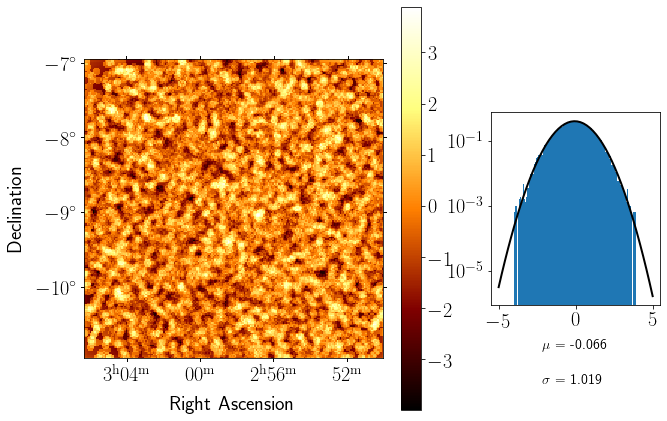

In [34]:
%%time
excess_maps_2 = excess_estimator.run(image_dataset)
plot_sqrt_ts_map(excess_maps_2["significance"].sum_over_axes())

#### d. Significance distribution (include only pixels within 2.25 deg radius)

In [42]:
sdbins = np.linspace(-5, 8, 131)
def get_binc(bins):
    bin_center = (bins[:-1] + bins[1:])/2
    return bin_center
reg_inner = CircleSkyRegion(position, 2.25*u.deg)
inner = geom.region_mask([reg_inner], inside=True)[0]

sign_inner = excess_maps['significance'].sum_over_axes().data[inner]

In [44]:
# Significance map with source excluded

map_sign_excl = excess_maps['significance'].copy()
sign_excl = map_sign_excl.sum_over_axes().data.copy()
sign_excl[~exclusion_mask.data[0].astype(bool)] = -999.
sign_excl_inner = sign_excl[inner]
sign_inner[np.isnan(sign_inner)] = -999.
sign_excl_inner[np.isnan(sign_excl_inner)] = -999.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


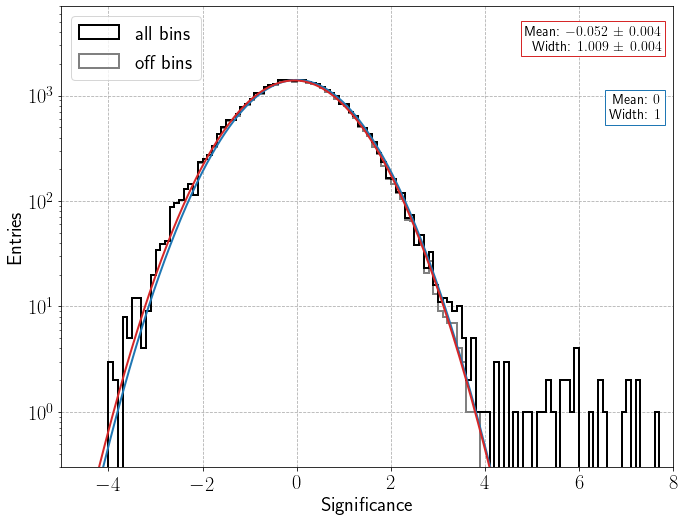

In [45]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_axes([0.12, 0.12, 0.85, 0.8])
ax.grid(ls='--')
ax.set_yscale('log')
ax.set_xlabel('Significance')
ax.set_ylabel('Entries')
h = ax.hist(sign_inner, bins=sdbins, histtype='step', color='k', lw=2, label = 'all bins', zorder=5)[0]
h = ax.hist(sign_excl_inner, bins=sdbins, histtype='step', color='gray', lw=2, label ='off bins',zorder=3)[0]

gaus = lambda x,amp,mean,sigma:amp*np.exp(-(x-mean)**2/2/sigma**2)
xv = np.linspace(sdbins[0], sdbins[-1], 1000)
res = scipy.optimize.curve_fit(gaus, get_binc(sdbins), h, p0=[h.max(), 0., 1.])
pars = res[0]
errs = np.sqrt(np.diag(res[1]))
ax.plot(xv, gaus(xv, pars[0], pars[1], pars[2]), color='tab:red', lw=2, zorder=7)

ax.text(0.98, 0.96, 'Mean: ${:.3f}\,\pm\,{:.3f}$\nWidth: ${:.3f}\,\pm\,{:.3f}$'.format(pars[1], errs[1], pars[2], errs[2]),
        ha='right', va='top', bbox=dict(edgecolor='tab:red', facecolor='white'), transform=ax.transAxes)

ax.plot(xv, gaus(xv, h.max(), 0, 1), color='tab:blue', lw=2, zorder=6)

ax.text(0.98, 0.81, 'Mean: $0$\nWidth: $1$', ha='right', va='top',
        bbox=dict(edgecolor='tab:blue', facecolor='white'), transform=ax.transAxes)

ax.set_xlim(sdbins[0], sdbins[-1])
ax.set_ylim(bottom=0.3)
ax.legend(loc = 'upper left', fontsize = 20)
#format_log_axis(ax.yaxis)
save(fig, "3d_2D_fitting_Sign_distribution")

# Estimate source position errors
- To constrain the source position we compute the `Fit.confidence`. It returns the asymetric errors on a parameter following the actual maximum likelihood ratio profile.

In [46]:
%%time
conf_lon = fit_2d.confidence(spatial_model.lon_0)
conf_lat = fit_2d.confidence(spatial_model.lat_0)

CPU times: user 498 ms, sys: 13.7 ms, total: 512 ms
Wall time: 513 ms


- Additionally, the `Fit` uses Minuit. We can compute error contours from Minos.

In [47]:
%%time
contours_1 = fit_2d.minos_contour(spatial_model.lon_0, spatial_model.lat_0, numpoints=20 )
contours_2 = fit_2d.minos_contour(spatial_model.lon_0, spatial_model.lat_0, numpoints=20, sigma=2)

CPU times: user 14.1 s, sys: 179 ms, total: 14.2 s
Wall time: 14.3 s


- In the End, we plot the contours.

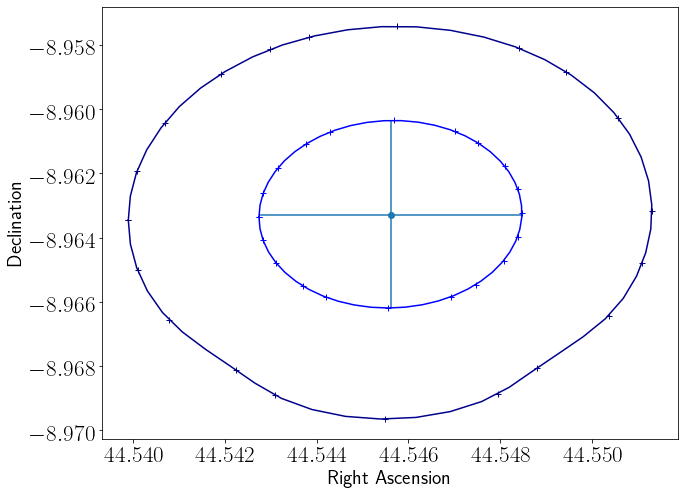

In [63]:
W = 10

params = {'figure.figsize': (W, W/(4/3)),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large',
          'font.size' : 16,
         'text.usetex': True,
          'font.family': "sans-serif",
          'legend.fontsize': 16,
          }
plt.rcParams.update(params)


fig = plt.figure()
ax=plt.subplot()
plot_contour_line(ax=ax, x=contours_1['x'], y=contours_1['y'],color = 'blue')
plot_contour_line(ax=ax, x=contours_2['x'], y=contours_2['y'], color = 'darkblue')
countour = plt.errorbar(x=[spatial_model.lon_0.value],
             y=[spatial_model.lat_0.value], 
             xerr=[[conf_lon["errn"]],[conf_lon["errp"]]],
             yerr=[[conf_lat["errn"]],[conf_lat["errp"]]],
             fmt='o'
            )

plt.xlabel('Right Ascension', fontsize= 20)
plt.ylabel('Declination', fontsize= 20)
save(fig, '3d_2d_fit_Source_position_contours')

**As a self-training:** I will try other fitting backends or different starting values. I will do it very soon in my free time after reporting!